In [1]:
import pandas as pd

# Data That Contains The Same 20 Songs from Testing and Training

In [2]:
training_target = pd.read_parquet("./datagame-2023/label_train_target.parquet")
training = pd.read_parquet('./datagame-2023/label_train_source.parquet')
testing = pd.read_parquet('./datagame-2023/label_test_source.parquet')

In [3]:
def createSongs(df, n):
    songs_per_session = df.sort_values('listening_order').groupby('session_id').head(n)
    new_df = songs_per_session.pivot_table(index='session_id', columns=songs_per_session.groupby('session_id').cumcount().add(1), values='song_id', aggfunc='first')
    new_df.columns = [f'song_{i}_id' for i in new_df.columns]
    new_df.reset_index(inplace=True)
    new_df = new_df.reset_index(drop=True)
    return new_df

training, testing = createSongs(training, 20), createSongs(testing, 20)
column_for_merging = list(training.columns[1:])


In [4]:
testing['count'] = testing[column_for_merging].apply(lambda row: len(row.unique()), axis=1)
training['count'] = training[column_for_merging].apply(lambda row: len(row.unique()), axis=1)

training_without_all_repeating = training[training['count'] != 1].drop('count', axis=1)
testing_without_all_repeating = testing[testing['count'] != 1].drop('count', axis=1)

merged_df = pd.merge(testing_without_all_repeating, training_without_all_repeating, on=column_for_merging, how='inner')
merged_data_with_same_values = merged_df.drop_duplicates(subset='session_id_x')


# To CSV

In [5]:

training_target = createSongs(training_target, 5)

In [6]:
training_target_repeating = training_target.copy()
training_target_repeating['count'] = training_target_repeating.drop("session_id", axis=1).apply(lambda row: len(row.unique()), axis=1)
exclusive_target = training_target_repeating[training_target_repeating['count'] == 5].drop("count", axis=1)

In [7]:
sample_train_id = merged_data_with_same_values[['session_id_y']]
sample_train_id.columns = ['session_id']
merged_sample = sample_train_id.merge(exclusive_target, on='session_id', how='left')
renamed_sample = merged_sample.rename(columns={'session_id': 'session_id_y'})

In [8]:
merged_sample = merged_data_with_same_values.merge(renamed_sample, on='session_id_y', how='left')
merged_sample.drop_duplicates(subset=['session_id_x'], inplace=True)


In [9]:
sample = pd.read_csv('./datagame-2023/sample.csv')

In [10]:
renamed_merged_sample = merged_sample.rename(columns={'session_id_x': "session_id"})


In [11]:
targeted_sample = sample.merge(renamed_merged_sample, on='session_id', how='left')

In [12]:

targeted_sample.iloc[:, 1:6] = targeted_sample.iloc[:, 27:]

In [13]:
final = targeted_sample.iloc[:, :6]
final.to_csv("same_df.csv", index=False)

# Plotting

Text(0, 0.5, 'The number of pieces of data')

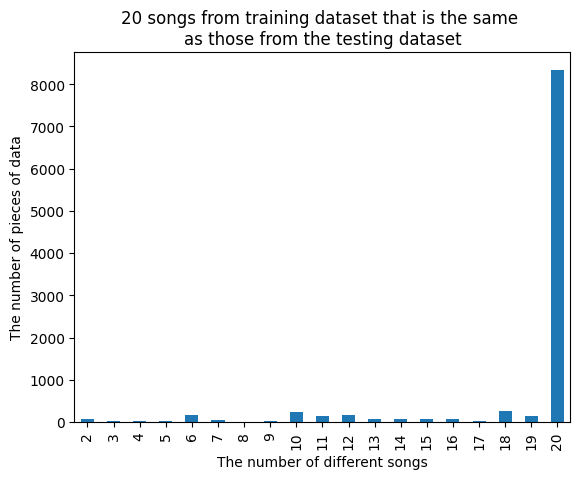

In [14]:
from matplotlib import pyplot as plt

testing_merged_id, training_merged_id = merged_data_with_same_values[['session_id_x']], merged_data_with_same_values[['session_id_y']]
training_merged_id.columns = ['session_id']

training_merged_id.merge(training, on='session_id', how='left')['count'].value_counts().sort_index()

testing_merged_id.columns = ['session_id']
testing_merged_id.merge(testing, on='session_id', how='left')['count'].value_counts().sort_index().plot(kind='bar')
plt.title("20 songs from training dataset that is the same \nas those from the testing dataset")
plt.xlabel('The number of different songs')
plt.ylabel('The number of pieces of data')